# Notebook to make figure for initial shelfstrat conditions.
> - Make several subplots and combine them offline 
> - Plot a plan view of salinity with isohalines overlaid
> - cross sections of potential temperature and alongshore velocity

In [1]:
#Packages 
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime
import glob
from xhistogram.xarray import histogram
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.ticker as tick
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
from xhistogram.xarray import histogram
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore") #The chaotic option, used to suppress issues with cf_time with xroms 

### Open model output 

In [2]:
path1 = '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_uwind_0_f_43N/shelf_dx_500_uwind_0_f_43N_open_his.nc'
ds = xroms.open_netcdf(path1)
ds, grid = xroms.roms_dataset(ds)

In [3]:
#Interpolate vertical coordinate for plotting
zw_u = grid.interp(ds.z_w, 'X')
zw_u = zw_u.assign_coords({"x_u": ds.x_u})

#x/y coordinates
xrho = (ds.x_rho/1000).values
yrho = (ds.y_rho/1000).values

#Temperature
temp = grid.interp(ds.temp,'X')
temp = temp.assign_coords({'z_rho_u':(ds.z_rho_u),'y_u':(ds.y_u),'xi_u':(ds.xi_u)})

#Density from linear EOS
rhol = 1027*((1+7.6*(10**-4*(ds.salt-35)))-1.7*10**-4*(ds.temp-25))
rhol = grid.interp(rhol,'X')
rhol = grid.interp(rhol,'Z', boundary = 'extend')
rhol = rhol.assign_coords({'z_w_u':(ds.z_w_u),'y_u':(ds.y_u)})

In [4]:
#print the extrema to check colorbar
print(temp.isel(ocean_time = 0, xi_u = 50, eta_rho = slice(1,-1)).min().values)
print(temp.isel(ocean_time = 0, xi_u = 50, eta_rho = slice(1,-1)).max().values)
print(ds.u.isel(ocean_time = 0, xi_u = 50, eta_rho = slice(1,-1)).min().values)
print(ds.u.isel(ocean_time = 0, xi_u = 50, eta_rho = slice(1,-1)).max().values)

19.35046
25.0
6.069931e-06
0.5334603


### Plan view of salinity 

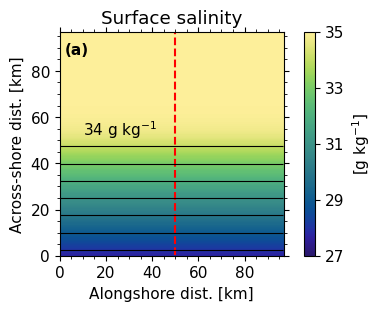

In [5]:
plt.rcParams.update({'font.size': 11})
nrows = 1; ncols = 1
fig, ax = plt.subplots(nrows,ncols, figsize = (4,3), constrained_layout = True)

#Plot plan view of surface salinity 
m = ax.pcolormesh(xrho, yrho, ds.salt[0,-1].values, cmap = cmo.haline, vmin = 27, vmax = 35)
cbar = fig.colorbar(m, ax = ax, label = '[g kg$^{-1}$]', ticks = [27, 29, 31, 33, 35])
ax.plot(ds.x_u[:,99]/1000, ds.y_u[:,99]/1000, lw = 1.5, ls = '--', c = 'r')
ax.contour(xrho, yrho, ds.salt[0,-1].values, levels = np.arange(28,36), colors = 'black', linewidths = 0.8, inline = True)

#Add subplot labels 
ax.text(2,87,'(a)', fontweight = 'semibold')
ax.set(xlim=[0,97], ylim=[0,97])

#Add some minor ticks and manually label them so they look nice
ax.set_xticks(np.arange(0,100,20))
minor_locator = AutoMinorLocator(2)
ax.tick_params(which = 'both',bottom=True, top=True, left=True, right=True)
ax.tick_params(which = 'both',labelbottom=True, labeltop=False, labelleft=True, labelright=False)
ax.minorticks_on()
ax.set_xticks([0,20,40,60,80])
ax.set_xticklabels(['0', '20', '40', '60', '80'])
ax.set_yticks([0,20,40,60,80])
ax.set_yticklabels(['0', '20', '40', '60', '80'])
ax.set_xlabel('Alongshore dist. [km]')
ax.set_ylabel('Across-shore dist. [km]')
ax.set_title('Surface salinity')
ax.set_aspect('equal')
ax.text(10,52, r'34 g kg$^{-1}$', color = 'black')

plt.savefig('output/figs/initial_salinity.png', dpi = 300, bbox_tight= True)

### Cross-sections of $\theta$ and $u$

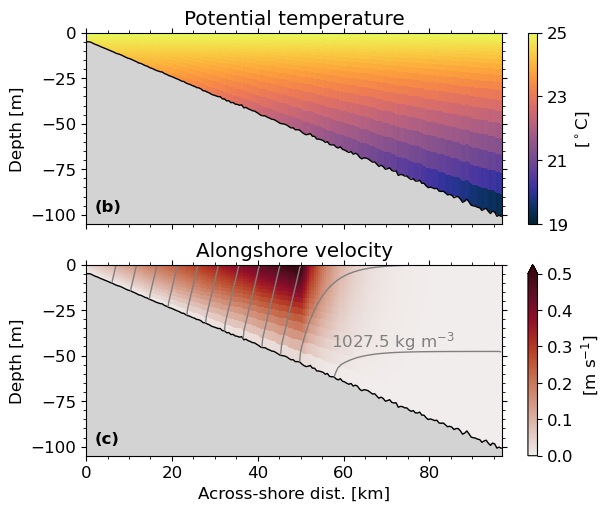

In [6]:
plt.rcParams.update({'font.size': 12})
nrows = 2; ncols = 1
fig, ax = plt.subplots(nrows,ncols, figsize = (6,5), constrained_layout = True)

#Plot cross-section of potential temp
tp = temp.isel(ocean_time = 0, xi_u = 50).plot(ax = ax[0], x = 'y_u', y = 'z_rho_u', 
                                               cmap = cmo.thermal, vmin = 19, vmax = 25, add_colorbar = False)
cbar = fig.colorbar(tp, ax = ax[0], label = '[$^\circ$C]', ticks = [19,21,23,25])
zw_u.isel(ocean_time = 0, s_w = 0, xi_u = 50).plot(ax = ax[0], x = 'y_u', c = 'k', lw = 1.0)

#Plot cross section of u velocity with density contours 
uplt = ds.u.isel(ocean_time = 0, xi_u = 50).plot(ax = ax[1], x = 'y_u', y = 'z_rho_u', 
                                                 cmap = cmo.amp, vmin = 0, vmax = 0.5, add_colorbar = False)
zw_u.isel(ocean_time = 0, s_w = 0, xi_u = 50).plot(ax = ax[1], x = 'y_u', c = 'k', lw = 1)

rhoplt = rhol.isel(ocean_time = 0, xi_u = 50).plot.contour(x = 'y_u', y = 'z_w_u', levels = np.arange(1022,1030,0.5),                                                            
                                                           colors = 'gray', inline = False, linewidths = 1)
cbar = fig.colorbar(uplt, ax = ax[1], label = '[m s$^{-1}$]', extend = 'max')

for i in range(2):
    ax[i].set_ylim(-105,0)
    ax[i].set_xlabel('Across-shore dist. [km]')
    ax[i].set_xticklabels(['0', '20', '40', '60', '80'])
    ax[i].set_xticks([0,20e3,40e3,60e3,80e3])
    ax[i].tick_params(which = 'both',bottom=True, top=True, left=True, right=True)
    ax[i].tick_params(which = 'both',labelbottom=True, labeltop=False, labelleft=True, labelright=False)
    ax[i].minorticks_on()
    ax[i].set_ylabel('Depth [m]')
    
ax[0].set_xticklabels('')
ax[0].set_xlabel('')
ax[0].set_title(r'Potential temperature')
ax[0].text(2000,-98,'(b)', fontweight = 'semibold')
ax[0].set_facecolor('lightgray')

ax[1].set_title(r'Alongshore velocity')
ax[1].text(2000,-98,'(c)', fontweight = 'semibold')
ax[1].text(57e3, -45, '1027.5 kg m$^{-3}$', color = 'gray')
ax[1].set_facecolor('lightgray')

plt.savefig('output/figs/initial_cs.png', dpi = 300, bbox_tight= True)

### Get vertical resolution in top 1 m averaged over initially stratified region and whole domain for model setup

In [7]:
print(ds.dz[0].where(ds.z_rho[0]>-1).mean().values)
print(ds.dz[0,:,1:100,1:-1].where(ds.z_rho[0,:,1:100,1:-1]>-1).mean().values)
print(ds.dz[0].mean().values)
print(ds.dz[0,:,1:100,1:-1].mean().values)

0.18908855184648748
0.16406689667626898
1.7582916900258896
0.9832977269069176
